# Importing Necessary Modules

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from sklearn.metrics import confusion_matrix

# Load Dataset

In [72]:
df = pd.read_csv('../../datasets/PCOS_clean_data_without_infertility.csv')
df.head(12)

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,28,44.6,152.0,19.30,15,78,22,10.48,0,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,0,36,65.0,161.5,24.92,15,74,20,11.70,0,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,1,33,68.8,165.0,25.27,11,72,18,11.80,0,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,0,37,65.0,148.0,29.67,13,72,20,12.00,0,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,0,25,52.0,161.0,20.06,11,72,18,10.00,0,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
5,0,36,74.1,165.0,27.22,15,78,28,11.20,0,...,0,0.0,0,110,70,9,6,16.0,20.0,8.0
6,0,34,64.0,156.0,26.30,11,72,18,10.90,0,...,0,0.0,0,120,80,6,6,15.0,16.0,6.8
7,0,33,58.5,159.0,23.14,13,72,20,11.00,0,...,0,0.0,0,120,80,7,6,15.0,18.0,7.1
8,0,32,40.0,158.0,16.02,11,72,18,11.80,0,...,0,0.0,0,120,80,5,7,17.0,17.0,4.2
9,0,36,52.0,150.0,23.11,15,80,20,10.00,1,...,0,0.0,0,110,80,1,1,14.0,17.0,2.5


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              538 non-null    int64  
 1   Age (yrs)               538 non-null    int64  
 2   Weight (Kg)             538 non-null    float64
 3   Height(Cm)              538 non-null    float64
 4   BMI                     538 non-null    float64
 5   Blood Group             538 non-null    int64  
 6   Pulse rate(bpm)         538 non-null    int64  
 7   RR (breaths/min)        538 non-null    int64  
 8   Hb(g/dl)                538 non-null    float64
 9   Cycle(R/I)              538 non-null    int64  
 10  Cycle length(days)      538 non-null    int64  
 11  Marraige Status (Yrs)   538 non-null    float64
 12  Pregnant(Y/N)           538 non-null    int64  
 13  No. of aborptions       538 non-null    int64  
 14  I   beta-HCG(mIU/mL)    538 non-null    fl

In [74]:
X = df.drop(["PCOS (Y/N)",
            "Blood Group",
            "Height(Cm)",
            "Pregnant(Y/N)",
             "PRG(ng/mL)",
            "RR (breaths/min)",
            "No. of aborptions",
            "FSH/LH",
            "I   beta-HCG(mIU/mL)",
            "II    beta-HCG(mIU/mL)",
            "TSH (mIU/L)",
            "FSH(mIU/mL)",
            "LH(mIU/mL)",
            "Waist:Hip Ratio",
            "PRL(ng/mL)",
            "BP _Diastolic (mmHg)",
            "BP _Systolic (mmHg)",
            "Reg.Exercise(Y/N)",
            "RBS(mg/dl)"
            ],axis=1)

In [75]:
y = df[["PCOS (Y/N)"]]

# Data Augmentation

## Resampling on Complete Dataset

In [76]:
from imblearn.combine import SMOTEENN

resample = SMOTEENN(sampling_strategy="auto", random_state =0)
X, y = resample.fit_sample(X, y)

## Splitting

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)

In [78]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.15, random_state=0, stratify= y_train)

In [79]:
X_train.shape

(325, 23)

In [80]:
X_test.shape

(96, 23)

In [81]:
X_dev.shape

(58, 23)

## Scaling

In [82]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_dev = scaler.transform(X_dev)
X_dev = pd.DataFrame(X_dev)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)


# Setting Column Names from dataset
X_train.columns = X.columns
X_test.columns = X.columns
X_dev.columns = X.columns

# CNN

In [83]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [85]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)

In [71]:
# y_train = y_train.to_numpy().reshape(y_train.shape[0], 1)

In [16]:
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 2)

In [17]:
# y_test = y_test.to_numpy().reshape(y_test.shape[0], 1)

In [18]:
X_dev = X_dev.to_numpy().reshape(X_dev.shape[0], X_dev.shape[1], 2)

In [19]:
# y_dev = y_dev.to_numpy().reshape(y_dev.shape[0], 1)

In [20]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_dev = to_categorical(y_dev, 2)

In [21]:
X_train.shape[:]

(325, 23, 1)

In [61]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(64, (3), activation='relu'))
model.add(layers.Conv2D(32, (3), activation='relu'))
model.add(layers.Conv1D(64, (3), activation='relu'))
model.add(layers.Conv1D(64, (5), activation='relu'))
model.add(layers.Conv1D(32, (5), activation='relu'))

In [57]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [62]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [63]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 23, 128)           256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2944)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               376960    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 32)              

In [64]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss', mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', 'Precision', 'Recall'])

In [66]:
history = model.fit(X_train,y_train, epochs=200, validation_data= (X_dev,y_dev));

Epoch 1/200
11/11 [==============================] - 0s 41ms/step - loss: 0.6777 - auc: 0.7254 - accuracy: 0.6400 - precision: 0.6221 - recall: 0.5877 - val_loss: 0.6275 - val_auc: 0.8722 - val_accuracy: 0.7931 - val_precision: 0.8298 - val_recall: 0.6724
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.5780 - auc: 0.9107 - accuracy: 0.8431 - precision: 0.8860 - recall: 0.7415 - val_loss: 0.4616 - val_auc: 0.9180 - val_accuracy: 0.8103 - val_precision: 0.8333 - val_recall: 0.7759
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.3692 - auc: 0.9528 - accuracy: 0.8800 - precision: 0.9006 - recall: 0.8646 - val_loss: 0.2707 - val_auc: 0.9670 - val_accuracy: 0.8966 - val_precision: 0.8966 - val_recall: 0.8966
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2840 - auc: 0.9495 - accuracy: 0.8985 - precision: 0.8936 - recall: 0.9046 - val_loss: 0.1589 - val_auc: 0.9884 - val_accuracy: 0.9138 - val_precision: 0.9153 

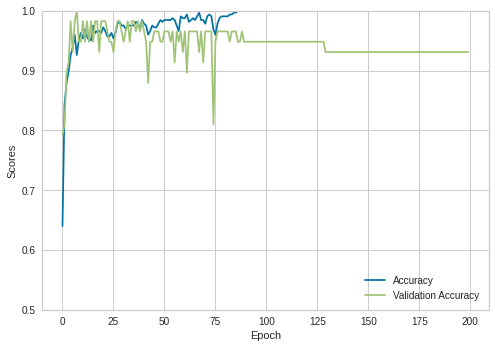

In [67]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

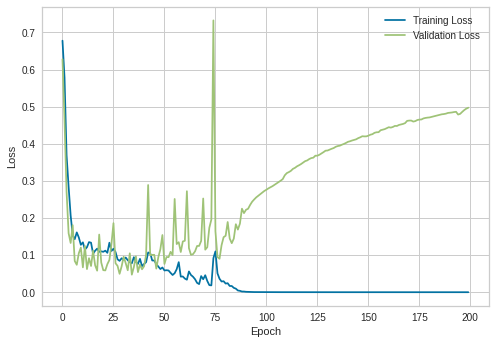

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [69]:
model.evaluate(X_test,  y_test, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 1.0897 - auc: 0.9252 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167


[1.0897427797317505,
 0.9252386689186096,
 0.9166666865348816,
 0.9166666865348816,
 0.9166666865348816]